# Recommendations to improve service

Through this notebook, we will be exploring a dataset structured as follows:
    - A stream id
    - An isp name
    - A browser name
    - A boolean "connected" with the value true if the user connected to the video during their session

The dataset also contains two other columns which indicate whether the stream was downloaded through p2p (and which cdn was involved in either cases).

Our goal is to extract relevant information in order to provide recommendations. These recommendations will be provided at the end of this notebook, after all observations have been made.

### Importing useful Python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Importing the data

In [2]:
filename = "data.csv"
df = pd.read_csv(filename)

We will try different approaches to try and extract information of different types in order to draw conclusions

### Checking the influence of every factor 

Let's clarify our reasoning:
The values in each dimension are not numerical (or their numerical values hold no meaning except for their differences). Given the low number of dimensions, we can try this approach to see if a dimension has an influence on the "connected" column independantly from other factors.

Another important noticeable aspect, is that the stream id is irrelevant to our understanding of the problem as it is not a technical aspect of the service that we can improve, but rather related to the content/ popularity of the video. We are thus assuming that all streams can be accessed to by the same means

####  ISP

In [3]:
# Keeping solely the columns with isp name and the "connected" column
isp_influence = df[df.columns[df.columns.isin(['isp', 'connected'])]]

# Seperating "False" and "True"
isp_influence_false = isp_influence[(isp_influence['connected'] == False)]
isp_influence_true = isp_influence[(isp_influence['connected'] == True)]

isp_influence_false = isp_influence_false['isp']
isp_influence_true = isp_influence_true['isp']

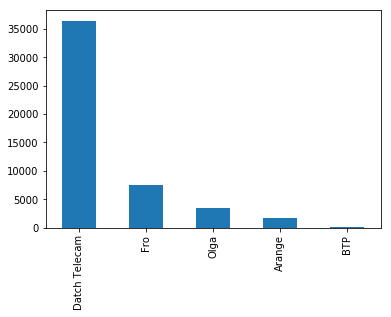

In [4]:
fig1 = isp_influence_false.value_counts().plot.bar()

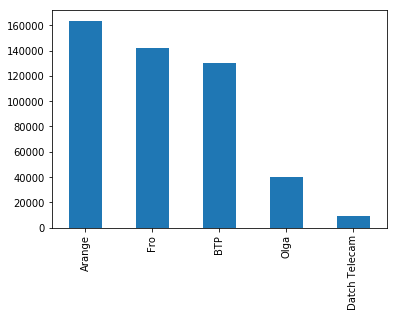

In [5]:
fig2 = isp_influence_true.value_counts().plot.bar()

From these two figures we can already see that the service provided is not very compatible with Datch Telecam users (probably the technologies used by the service cannot work together, or that p2p or cdn are not available with this ISP). To check the real problem, let's see what the "p2p" and "cdn" columns provide as additional information for Datch Telecam users who connected to the backend

In [6]:
isp_p2p = df[df.columns[df.columns.isin(['isp', 'connected', 'p2p', 'cdn'])]]

isp_p2p = isp_p2p[isp_p2p['isp'] == "Datch Telecam"]
datch_users = isp_p2p.shape[0]

isp_p2p = isp_p2p[(isp_p2p['connected'] == True) ]
datch_connected = isp_p2p.shape[0]

isp_p2p = isp_p2p[(isp_p2p['p2p'] == 0)]
datch_not_p2p = isp_p2p.shape[0]

In [7]:
print("Ratio of connected users for Datch Telecam: ", str(datch_connected / datch_users))
print("Ratio of connected users not using p2p : ", str(datch_not_p2p / datch_connected))

Ratio of connected users for Datch Telecam:  0.20238747125177964
Ratio of connected users not using p2p :  0.11320346320346321


The problem is thus not related to a p2p issue with Datch Telecam. We will now continue our exploration of the data.

In [8]:
# Keeping solely the columns with browser name and the "connected" column
browser_influence = df[df.columns[df.columns.isin(['browser', 'connected'])]]

# Seperating "False" and "True"
browser_influence_false = browser_influence[(browser_influence['connected'] == False)]
browser_influence_true = browser_influence[(browser_influence['connected'] == True)]

browser_influence_false = browser_influence_false['browser']
browser_influence_true = browser_influence_true['browser']

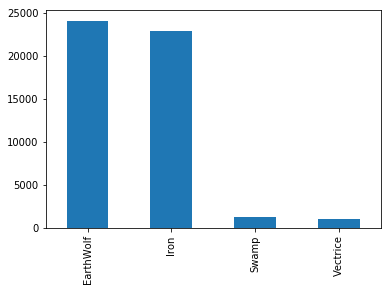

In [9]:
fig3 = browser_influence_false.value_counts().plot.bar()

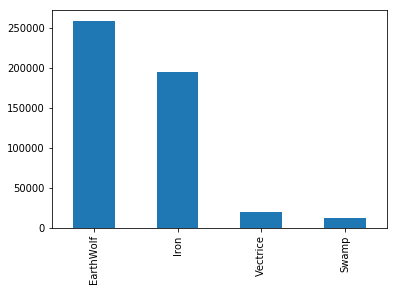

In [10]:
fig4 = browser_influence_true.value_counts().plot.bar()

At first sight, the browser choice does not seem to have a significant effect on the access ratio to the streams. Let's try to find out more

In [11]:
values_true = browser_influence_true.value_counts()
values_false = browser_influence_false.value_counts()
browsers = browser_influence.browser.unique()

In [12]:
ratios = list()

for browser in browsers:
    total = values_false[browser] + values_true[browser]
    ratios.append( values_false[browser] / total)

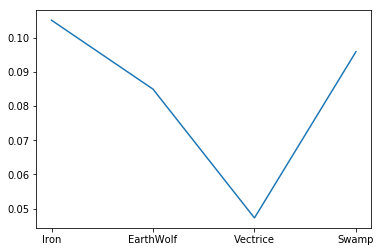

In [13]:
false_ratios_fig = plt.plot(browsers, ratios)
plt.show()

Although the ratios are within the same range, there is a slight difference between all browsers: the "Vectrice" browser is apparently the most well-suited one for access to the streams with a slight but clear advantage compared to others. The others are closer to each other and show approximately a 0.1 ratio of non-downloading of the stream.

### Checking correlations 

We will now try to see if joining two indicators can provide a better insight towards identifying the causes of non-access to the video contents.

We made the assumption that videos are identical when it comes to accessing them. The idea behind this, as we explained, is that any differences in connection ratios may be due to the content of the video and its popularity. However, this may change if it is associated with the browser or/isp that enabled this access. We will try to check that out.

In [14]:
cols_vals = list()

for col in ['#stream', 'browser', 'isp']:
        cols_vals.append(df[col].unique())

In [15]:
cols_vals

[array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array(['Iron', 'EarthWolf', 'Vectrice', 'Swamp'], dtype=object),
 array(['Fro', 'Arange', 'BTP', 'Datch Telecam', 'Olga'], dtype=object)]

Let's try to check any correrlations between ISPs and browsers

In [16]:
groups = list()
names = list()

for isp in cols_vals[2]:
    isps = df[(df['isp'] == isp)]
    for brow in cols_vals[1]:
        isp_brow = isps[isps['browser'] == brow]
        groups.append([isp, brow, isp_brow[isp_brow.columns[isp_brow.columns.isin(['#stream', 'connected'])]]])

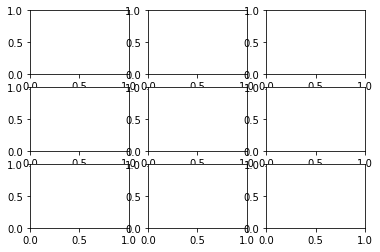

In [17]:
# Initializing figures
fig, axes = plt.subplots(nrows=3, ncols=3)
axes = axes.flatten()
names = list()

# Initializing data structures
n = len(cols_vals[0])
true_vals = list()
false_vals = list()
for i in range(n):
    true_vals.append([])
    false_vals.append([])

# Filling
for group in groups:
    name = group[0] + ", " + group[1]
    names.append(name)
    true_val = [0] * n
    false_val = [0] * n
    for i, row in group[2].iterrows():
        if row['connected'] :
            true_val[row['#stream']-1] += 1
        else :
            false_val[row['#stream']-1] += 1
    for i in range(n):
        true_vals[i].append(true_val[i])
        false_vals[i].append(false_val[i])

In [18]:
abcissae = [i+1 for i in range(len(names))]

for i in range(n):
    axes[i].plot(abcissae, true_vals[i], color="blue", label="Connected")
    axes[i].legend( prop = { 'size' : 0.2 })
    title = "Stream n°" + str(i + 1)
    axes[i].set_title(title)

fig.tight_layout()
fig.set_size_inches(20,10)

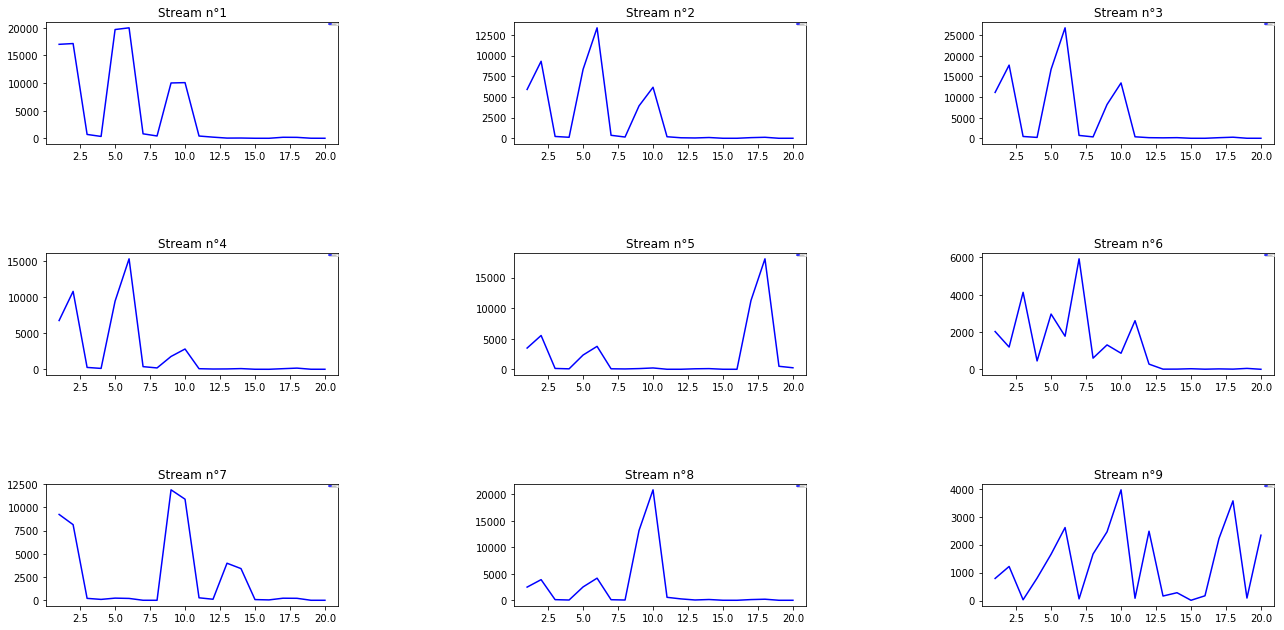

In [19]:
fig

* We will type our observations on these charts a little later

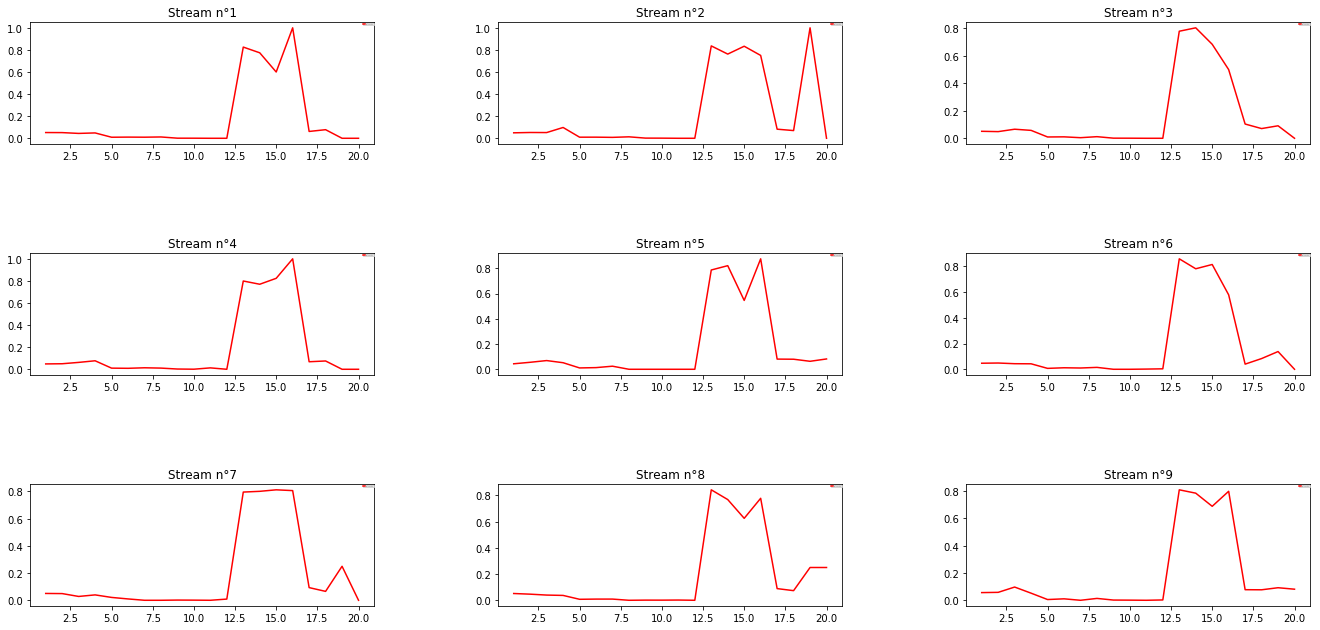

In [20]:
fig2, axes = plt.subplots(ncols=3, nrows=3)
axes = axes.flatten()

for i in range(n):
    for j in range(len(false_vals[i])):
        false_vals[i][j] = false_vals[i][j] / (false_vals[i][j] + true_vals[i][j])
    axes[i].plot(abcissae, false_vals[i], color="red", label="Not connected")
    axes[i].legend( prop = { 'size' : 1 })
    title = "Stream n°" + str(i+1)
    axes[i].set_title(title)

fig2.tight_layout()
fig2.set_size_inches(20,10)

In [21]:
for i in range(len(abcissae)):
    print(abcissae[i], " ", names[i])

1   Fro, Iron
2   Fro, EarthWolf
3   Fro, Vectrice
4   Fro, Swamp
5   Arange, Iron
6   Arange, EarthWolf
7   Arange, Vectrice
8   Arange, Swamp
9   BTP, Iron
10   BTP, EarthWolf
11   BTP, Vectrice
12   BTP, Swamp
13   Datch Telecam, Iron
14   Datch Telecam, EarthWolf
15   Datch Telecam, Vectrice
16   Datch Telecam, Swamp
17   Olga, Iron
18   Olga, EarthWolf
19   Olga, Vectrice
20   Olga, Swamp


After observing all these charts, it appears that our assumtion that the stream id has not effect was a valid one. 
We also have confirmed that there is a low user-connection ratio for "Datch Telecam" users (generally less that 0.3). There appears also to be a slight problem with the "Olga" ISP as the non-connected users is noticeably higher that other ISPs (except for "Datch Telecam" of course), with a peak when it comes to Stream n° 2 .

We would like to check the differenes in conversion ratios for other ISPs when compared to each other without *Datch Telecam* being present. Let's check that out.

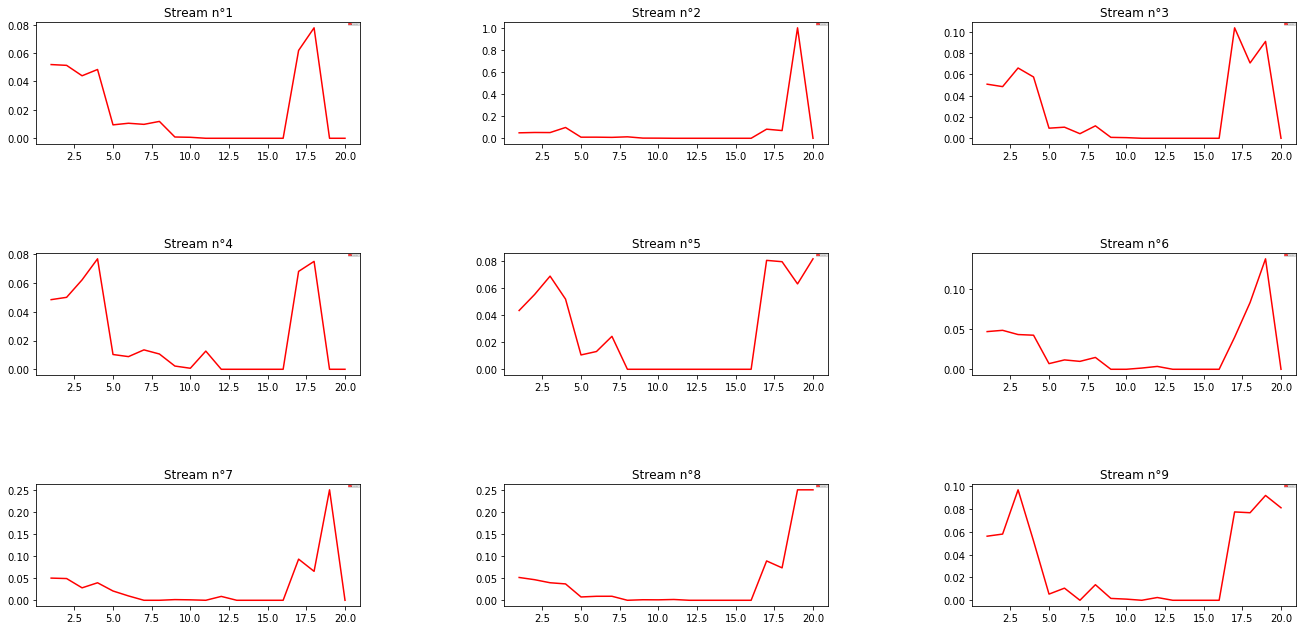

In [22]:
fig3, axes = plt.subplots(ncols=3, nrows=3)
axes = axes.flatten()

for i in range(n):
    for j in range(12, 16):
        false_vals[i][j] = 0
    axes[i].plot(abcissae, false_vals[i], color="red", label="Not connected")
    axes[i].legend( prop = { 'size' : 1 })
    title = "Stream n°" + str(i+1)
    axes[i].set_title(title)

fig3.tight_layout()
fig3.set_size_inches(20,10)

* These last charts confirm our suspicions when it comes to the *Olga* ISP : it has a relatively high "not connected" rate compared to others on average (with *Fro* right behind it for some streams).

* For the *true_vals* charts, what we observe in general is an oscillation between high values at the beginning of each ISP chunk and low values afterwards: this is only dure to the order of browsers with *Vectrice* and *Swamp* being the last ones, and the low values caused by their poor popularity.

## Recommendations (in order from least to most important)

* Check if there is a problem with *Stream n°2* when it comes to the *Olga* browser
* Improve the compatibility of the streaming with three browsers essentially in this order:
    * EarthWolf
    * Iron
    * Swamp

This order may be different than what the access ratio may infer, but it is mainly due to each browser's popularity, with *EarthWolf* being the most popular, and *Iron* being the second most popular. This ensures that more people will accede to the stream content.

* Improving service compatibility with the *Fro* and *Datch Telecam*, in this same order, for reasons of popularity among users (even if the technical issue is more remarkable with *Datch Telecam*).